In [2]:
import json

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from textwiser import TextWiser, Embedding, Transformation

## Goodreads Preprocessing
This notebook contains the preprocessing necessary to run the Goodreads experiments. Before running the code, download the young adult subset of Goodreads dataset [here](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home).

In [3]:
# Input
books_json = 'goodreads_books_young_adult.json'
interactions_json = 'goodreads_interactions_young_adult.json'
reviews_json = 'goodreads_reviews_young_adult.json'

# Output
responses_csv = 'responses.csv.gz'
user_features_csv = 'user_features.csv.gz'

We first get the relevent columns of the interactions. We binarize the interactions where any rating greater than or equal to 4 as a positive response, anything else is a negative response.

In [3]:
with open(interactions_json) as fp:
    interactions = []
    for line in fp:
        interactions.append(json.loads(line))
interactions = pd.DataFrame(interactions)
interactions = interactions[interactions['is_read']][['user_id', 'book_id', 'rating']]
interactions.head()

,user_id,book_id,rating
3,8842281e1d1347389f2ab93d60773d4d,8684868,3
4,8842281e1d1347389f2ab93d60773d4d,8423493,2
5,8842281e1d1347389f2ab93d60773d4d,87976,5
6,8842281e1d1347389f2ab93d60773d4d,18116,5
7,8842281e1d1347389f2ab93d60773d4d,2767052,5


<AxesSubplot:>

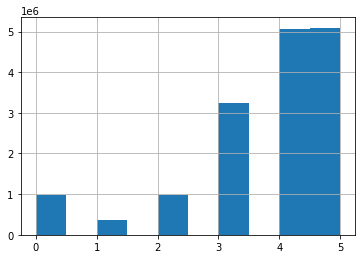

In [4]:
interactions['rating'].hist()

In [5]:
interactions['rating'].describe()

count    1.572275e+07
mean     3.672738e+00
std      1.373416e+00
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [6]:
interactions['response'] = interactions['rating'] >= 4
interactions.drop('rating', axis=1, inplace=True)
interactions.head()

,user_id,book_id,response
3,8842281e1d1347389f2ab93d60773d4d,8684868,False
4,8842281e1d1347389f2ab93d60773d4d,8423493,False
5,8842281e1d1347389f2ab93d60773d4d,87976,True
6,8842281e1d1347389f2ab93d60773d4d,18116,True
7,8842281e1d1347389f2ab93d60773d4d,2767052,True


We then look at the reviews and limit the userbase to the subset where the users have reviews _and_ interactions.

In [63]:
with open(reviews_json) as fp:
    reviews = []
    for line in fp:
        reviews.append(json.loads(line))
reviews = pd.DataFrame(reviews)
reviews.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,2767052,248c011811e945eca861b5c31a549291,5,I cracked and finally picked this up. Very enj...,Wed Jan 13 13:38:25 -0800 2010,Wed Mar 22 11:46:36 -0700 2017,Sun Mar 25 00:00:00 -0700 2012,Fri Mar 23 00:00:00 -0700 2012,24,25
1,7504b2aee1ecb5b2872d3da381c6c91e,23302416,84c0936a0f9868f38e75d2f9a5cb761e,5,I read this book because my fifth grade son wa...,Wed Jan 21 18:40:59 -0800 2015,Wed Oct 26 03:44:13 -0700 2016,,,0,0
2,f8a89075dc6de14857561522e729f82c,18053080,785c8db878f4009da9741dea51f641da,4,Though the book started out slow and only star...,Sat Jan 11 17:58:41 -0800 2014,Tue Dec 02 11:43:07 -0800 2014,Sat Apr 12 00:00:00 -0700 2014,Fri Apr 11 00:00:00 -0700 2014,0,0
3,f8a89075dc6de14857561522e729f82c,17383543,34dc3c45d07e82718b05e73167259aef,2,"*Update - 10/27/13* - After some sleep, I thin...",Sun Apr 21 19:42:28 -0700 2013,Fri Aug 15 07:55:01 -0700 2014,Sat Oct 26 00:00:00 -0700 2013,Fri Oct 25 00:00:00 -0700 2013,0,0
4,f8a89075dc6de14857561522e729f82c,16651458,d8d6b590780256fef7ae4a9550fe3e0d,5,"This is a moving, heartbreaking, view into a l...",Fri Jan 11 11:42:42 -0800 2013,Fri Mar 01 09:31:01 -0800 2013,Mon Jan 14 00:00:00 -0800 2013,Sat Jan 12 00:00:00 -0800 2013,0,0


In [8]:
user_ids = np.intersect1d(interactions['user_id'].unique(), reviews['user_id'].unique())
print(user_ids.shape[0])
interactions = interactions[interactions['user_id'].isin(user_ids)]
reviews = reviews[reviews['user_id'].isin(user_ids)]

208711


In [10]:
interactions.to_csv(responses_csv, index=False)

We then go through the books dataset, calculating the most popular shelves.

In [4]:
with open(books_json) as fp:
    books = []
    for line in fp:
        books.append(json.loads(line))

books = pd.DataFrame(books)
books.head()

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,,1,[147734],US,,"[{'count': '1057', 'name': 'to-read'}, {'count...",B0056A00P4,true,4.04,B0056A00P4,...,,,,https://www.goodreads.com/book/show/12182387-t...,https://s.gr-assets.com/assets/nophoto/book/11...,12182387,4,285263,"The Passion (Dark Visions, #3)","The Passion (Dark Visions, #3)"
1,,2,[425995],US,,"[{'count': '1010', 'name': 'to-read'}, {'count...",B006KLYIAG,true,3.80,B006KLYIAG,...,,,,https://www.goodreads.com/book/show/20135365-h...,https://s.gr-assets.com/assets/nophoto/book/11...,20135365,5,18450480,Hope's Daughter,Hope's Daughter
2,0698143760,17,[493993],US,,"[{'count': '1799', 'name': 'fantasy'}, {'count...",,true,3.80,,...,3,,2014,https://www.goodreads.com/book/show/21401181-h...,https://images.gr-assets.com/books/1394747643m...,21401181,33,24802827,"Half Bad (Half Life, #1)","Half Bad (Half Life, #1)"
3,,9,[176160],US,eng,"[{'count': '7173', 'name': 'to-read'}, {'count...",B0042JSOQC,true,4.35,B004IYJDXY,...,,,,https://www.goodreads.com/book/show/10099492-t...,https://s.gr-assets.com/assets/nophoto/book/11...,10099492,152,10800440,Twelfth Grade Kills (The Chronicles of Vladimi...,Twelfth Grade Kills (The Chronicles of Vladimi...
4,0990662616,428,[],US,eng,"[{'count': '9481', 'name': 'to-read'}, {'count...",,false,3.71,B00MW0MTGE,...,10,Special Edition,2014,https://www.goodreads.com/book/show/22642971-t...,https://images.gr-assets.com/books/1406979059m...,22642971,1525,42144295,The Body Electric,The Body Electric


In [38]:
books['popular_shelves']

0        [{'count': '1057', 'name': 'to-read'}, {'count...
1        [{'count': '1010', 'name': 'to-read'}, {'count...
2        [{'count': '1799', 'name': 'fantasy'}, {'count...
3        [{'count': '7173', 'name': 'to-read'}, {'count...
4        [{'count': '9481', 'name': 'to-read'}, {'count...
                               ...                        
93393    [{'count': '2641', 'name': 'to-read'}, {'count...
93394    [{'count': '12325', 'name': 'to-read'}, {'coun...
93395    [{'count': '1684', 'name': 'to-read'}, {'count...
93396    [{'count': '2401', 'name': 'to-read'}, {'count...
93397    [{'count': '850', 'name': 'to-read'}, {'count'...
Name: popular_shelves, Length: 93398, dtype: object

In [44]:
from collections import Counter
from collections import ChainMap

shelves = sum(books['popular_shelves'].apply(lambda x: Counter(ChainMap(*[{t['name']: int(t['count'])} for t in x]))), Counter())
shelves

Counter({'vampire': 1417327,
         'mystery': 1972902,
         '2011-reads': 41117,
         'fantasy-sci-fi': 897204,
         's-dark-visions': 26,
         '3st-in-series': 14,
         'audiobook': 2722019,
         'audio': 1533413,
         'teen-favorites': 257,
         'esp': 122,
         'when-i-was-young': 2068,
         'epubs': 2167,
         '4-stars': 1020101,
         'my-ebooks': 11496,
         'female-protagonist': 20146,
         'teen-fantasy': 11896,
         'read-in-english': 905231,
         'childhood-reads': 61139,
         '8th-grade': 8072,
         'czech': 566,
         'lj-smith-dark-visions': 26,
         'sort': 1227,
         'teenage-years': 616,
         'mystery-suspense': 37534,
         'romantic': 48630,
         '3-star': 4531,
         'adventure': 3937762,
         'back-in-the-day': 1012,
         'fantasy-paranormal': 205961,
         'superpowers': 17666,
         'ready-to-read': 962,
         'paperback': 124814,
         'in-czech'

We use the top 100 most common shelves as genres. We create binary features for all books based on whether a book contains one of the top 100 shelves.

In order to weed-out the false positives, we only look at the top 5 shelves for each book.

In [47]:
shelf_names = [t[0] for t in shelves.most_common(100)]

In [53]:
shelves_per_book = books['popular_shelves'].str[:5].apply(lambda x: [t['name'] for t in x])
shelves_per_book

0          [to-read, young-adult, ya, paranormal, fantasy]
1        [to-read, sci-fi, young-adult, dystopia, dysto...
2        [fantasy, young-adult, ya, favorites, books-i-...
3        [to-read, vampires, currently-reading, young-a...
4        [to-read, young-adult, sci-fi, science-fiction...
                               ...                        
93393    [to-read, favorites, young-adult, paranormal, ...
93394    [to-read, young-adult, ya, contemporary, fiction]
93395      [to-read, young-adult, ya, australian, romance]
93396    [to-read, currently-reading, young-adult, ya, ...
93397    [to-read, young-adult, paranormal, fantasy, ki...
Name: popular_shelves, Length: 93398, dtype: object

In [66]:
contains_shelf = pd.concat([books['book_id']] + [shelves_per_book.apply(lambda x: shelf_name in x) for shelf_name in shelf_names], axis=1)
contains_shelf.columns = ['book_id'] + shelf_names
contains_shelf.head()

,book_id,to-read,favorites,young-adult,currently-reading,fantasy,ya,books-i-own,fiction,romance,...,read-2013,scifi,faves,hunger-games,did-not-finish,english,lgbt,reread,e-books,rick-riordan
0,12182387,True,False,True,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,20135365,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,21401181,False,True,True,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,10099492,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,22642971,True,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Since we don't have any user features, we construct user features by going through the user reviews and featurizing them using TfIdf + NMF combination. We use the [TextWiser library](https://github.com/fidelity/textwiser) to generate the review features.

In [11]:
np.random.seed(42)
tw = TextWiser(Embedding.TfIdf(), Transformation.NMF(n_components=30))
review_vectors = tw.fit_transform(reviews['review_text'].values)

/Users/a649166/Tools/miniconda3/envs/atlas_base/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/a649166/Tools/miniconda3/envs/atlas_base/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [12]:
feat_cols = [f'feat_{i}' for i in range(review_vectors.shape[1])]

reviews = pd.concat([
    reviews.reset_index(drop=True),
    pd.DataFrame(review_vectors, columns=feat_cols),
], axis=1)
reviews.loc[reviews['rating'] == 0, 'rating'] = 1

The first set of user features are the aggregated review vectors over all the books the user has consumed.

In [13]:
user_features = reviews.groupby('user_id').apply(lambda x: pd.Series(np.mean(x[feat_cols], axis=0), index=feat_cols))
user_features = user_features.reset_index()
user_features

,user_id,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29
0,00000377eea48021d3002730d56aca9a,0.000000,0.008206,0.000000,0.000000,0.013352,0.006544,0.000000,0.000000,0.000000,...,0.005684,0.000000,0.000000,0.000229,0.000000e+00,0.000000,0.000000,0.006934,0.025350,1.875596e-04
1,00009e46d18f223a82b22da38586b605,0.000076,0.006519,0.000009,0.000860,0.004576,0.001978,0.000135,0.001225,0.000869,...,0.001162,0.003795,0.002570,0.001258,2.026162e-07,0.003861,0.000399,0.002067,0.003090,7.721762e-04
2,0000c3d51aa099745e93a4e99c4856c8,0.001248,0.003721,0.000594,0.000242,0.007567,0.003567,0.006358,0.001862,0.001025,...,0.001576,0.001612,0.001341,0.003375,1.490708e-04,0.003681,0.003806,0.001224,0.003678,1.142497e-03
3,0001085188e302fc6b2568de45a5f56b,0.004398,0.006148,0.002103,0.000484,0.019721,0.002422,0.000039,0.001820,0.001387,...,0.002996,0.008261,0.000142,0.005712,7.837327e-05,0.010146,0.007949,0.000000,0.001871,0.000000e+00
4,000157a6f8331e9c9a21252e1fee91d1,0.000000,0.003410,0.010195,0.000560,0.003218,0.001702,0.000000,0.000000,0.000493,...,0.000000,0.000000,0.000000,0.003095,0.000000e+00,0.002982,0.005427,0.000000,0.000000,7.167383e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208706,ffff7cafdaf5196383cb2efca08fb6fe,0.003557,0.003493,0.000263,0.000179,0.006302,0.002072,0.000585,0.000661,0.001160,...,0.001746,0.001693,0.002650,0.002649,1.307847e-04,0.003023,0.003618,0.001619,0.001937,1.327879e-03
208707,ffff7cf38c717c8172ff5ba656cec6df,0.000000,0.000025,0.000000,0.044537,0.000143,0.000037,0.000000,0.000000,0.000000,...,0.000000,0.000020,0.000000,0.000000,1.214774e-04,0.000000,0.000258,0.000000,0.000000,8.526145e-05
208708,ffff943e2e329be4f410d874aaa3ae7f,0.000000,0.000000,0.000000,0.000000,0.014030,0.005899,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.006845,0.000000,0.000000,0.000000,3.644790e-05
208709,ffffbb062a8b208c9c1031b529c08f7a,0.000000,0.000000,0.000000,0.000121,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000188,6.510028e-02,0.000000,0.000000,0.000463,0.000003,8.368034e-07


We also use create a train/test split based on the users.

In [20]:
train_inds, test_inds = train_test_split(np.arange(user_features.shape[0]), test_size=0.3, random_state=40)
user_features.loc[train_inds, 'set'] = 'train'
user_features.loc[test_inds, 'set'] = 'test'
user_features.head()

,user_id,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,set
0,00000377eea48021d3002730d56aca9a,0.000000,0.008206,0.000000,0.000000,0.013352,0.006544,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000229,0.000000e+00,0.000000,0.000000,0.006934,0.025350,0.000188,train
1,00009e46d18f223a82b22da38586b605,0.000076,0.006519,0.000009,0.000860,0.004576,0.001978,0.000135,0.001225,0.000869,...,0.003795,0.002570,0.001258,2.026162e-07,0.003861,0.000399,0.002067,0.003090,0.000772,test
2,0000c3d51aa099745e93a4e99c4856c8,0.001248,0.003721,0.000594,0.000242,0.007567,0.003567,0.006358,0.001862,0.001025,...,0.001612,0.001341,0.003375,1.490708e-04,0.003681,0.003806,0.001224,0.003678,0.001142,test
3,0001085188e302fc6b2568de45a5f56b,0.004398,0.006148,0.002103,0.000484,0.019721,0.002422,0.000039,0.001820,0.001387,...,0.008261,0.000142,0.005712,7.837327e-05,0.010146,0.007949,0.000000,0.001871,0.000000,train
4,000157a6f8331e9c9a21252e1fee91d1,0.000000,0.003410,0.010195,0.000560,0.003218,0.001702,0.000000,0.000000,0.000493,...,0.000000,0.000000,0.003095,0.000000e+00,0.002982,0.005427,0.000000,0.000000,0.000717,test


In [21]:
user_features.to_csv(user_features_csv, index=False)

In [72]:
interactions = pd.read_csv(responses_csv, dtype={'book_id': str})
interactions.head()

,user_id,book_id,response
0,8842281e1d1347389f2ab93d60773d4d,8684868,False
1,8842281e1d1347389f2ab93d60773d4d,8423493,False
2,8842281e1d1347389f2ab93d60773d4d,87976,True
3,8842281e1d1347389f2ab93d60773d4d,18116,True
4,8842281e1d1347389f2ab93d60773d4d,2767052,True


The second set of features we have for users are whether the user has read any book from a given genre/shelf.

In [75]:
user_features = pd.read_csv(user_features_csv)

In [79]:
user_genre = interactions.join(contains_shelf.set_index('book_id'), on='book_id').groupby('user_id').max()
user_genre.drop(columns=['book_id', 'response'], inplace=True)
user_genre.head()

,to-read,favorites,young-adult,currently-reading,fantasy,ya,books-i-own,fiction,romance,owned,...,read-2013,scifi,faves,hunger-games,did-not-finish,english,lgbt,reread,e-books,rick-riordan
user_id,,,,,,,,,,,,,,,,,,,,,
00000377eea48021d3002730d56aca9a,True,True,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
00009e46d18f223a82b22da38586b605,True,True,True,True,True,True,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
0000c3d51aa099745e93a4e99c4856c8,True,True,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
0001085188e302fc6b2568de45a5f56b,True,True,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
000157a6f8331e9c9a21252e1fee91d1,True,True,True,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [80]:
user_genre.shape

(208711, 100)

In [90]:
user_features = user_features.join(user_genre, on='user_id')
user_features.head()

,user_id,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,read-2013,scifi,faves,hunger-games,did-not-finish,english,lgbt,reread,e-books,rick-riordan
0,00000377eea48021d3002730d56aca9a,0.000000,0.008206,0.000000,0.000000,0.013352,0.006544,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,False,False,False,False
1,00009e46d18f223a82b22da38586b605,0.000076,0.006519,0.000009,0.000860,0.004576,0.001978,0.000135,0.001225,0.000869,...,False,False,False,False,False,False,False,False,False,False
2,0000c3d51aa099745e93a4e99c4856c8,0.001248,0.003721,0.000594,0.000242,0.007567,0.003567,0.006358,0.001862,0.001025,...,False,False,False,False,False,False,False,False,False,False
3,0001085188e302fc6b2568de45a5f56b,0.004398,0.006148,0.002103,0.000484,0.019721,0.002422,0.000039,0.001820,0.001387,...,False,False,False,False,False,False,False,False,False,False
4,000157a6f8331e9c9a21252e1fee91d1,0.000000,0.003410,0.010195,0.000560,0.003218,0.001702,0.000000,0.000000,0.000493,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
user_features.to_csv(user_features_csv, index=False)

At the end, we have two data files:
1. User Features, which contains the averaged TfIdf-NMF vectors of all books the user has read, and whether the user has read a book that is in one of the top 100 shelves. This data also contains a column that indicates whether a user is in the test set or in the train set.
2. Response matrix, which contains user/item/binary response tuples.